# Health Center Funding - Data Wrangling

## Overview
Now that I have cleaned the data and replaced odd characters with NaN values, I need to wrangle the data to get it in a format that will be condusive for EDA.

### Summary of Steps to Be Taken
1. I need to consolidate these dataframes with relevant features and data into one dataframe. Each dataframe provides information that is relevant for analysis, although some transformations and aggregations are required to get each ready.
2.  Each dataframe has null values that will need to be delt with in differnt ways. During data import and cleaning, I removed special characters and replaced them with NaN values, and they all need to be delt with in different ways since they result from different reporting requirements.
3. Finally, I will combine the clean dataframes into 1 dataframe for further EDA, visualization, and model development. 

In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from configuration.config import DATA_PATH

%matplotlib inline

In [3]:
# read in pandas dataframes for service area, health centers, and health center ops/finance
service_sites = pd.read_csv(DATA_PATH + 'service_sites_df.csv')
service_area = pd.read_csv(DATA_PATH + 'service_area_df.csv')
health_centers = pd.read_csv(DATA_PATH + 'health_center_combined.csv')
health_center_ops_finance = pd.read_csv(DATA_PATH + 'health_center_ops_finance.csv')

In [4]:
print('Shape of Service area dataframe: ', service_sites.shape)
print('Shape of Service sites dataframe: ', service_area.shape)
print('Shape of Health centers dataframe: ', health_centers.shape)
print('Shape of Health centers operations and finance dataframe: ', health_center_ops_finance.shape)

Shape of Service area dataframe:  (14987, 12)
Shape of Service sites dataframe:  (97142, 10)
Shape of Health centers dataframe:  (1370, 57)
Shape of Health centers operations and finance dataframe:  (1370, 34)


## Service Area dataframe
I want to take a look at the service area dataframe to determine what values I'll keep for further analysis.

Null values in this dataframe represent zip codes where organizations have served patients but served between 1 and 15 people. Due to the small number of people being served in an area, the total number of patients is hidden to protect patient information. 

In [5]:
service_area.head()

,BHCMISID,GrantNumber,ReportingYear,ZipCode,ZipCodeType,None_UninsuredPatients,Medicaid_CHIP_OtherPublicPatients,MedicarePatients,PrivatePatients,TotalNumberofPatients
0,010030,H80CS00803,2022,1011,ZipCode,NaN,NaN,0.0,NaN,NaN
1,010030,H80CS00803,2022,1013,ZipCode,61.0,1346.0,385.0,182.0,1974.0
2,010030,H80CS00803,2022,1014,ZipCode,0.0,NaN,NaN,0.0,21.0
3,010030,H80CS00803,2022,1104,ZipCode,26.0,791.0,181.0,97.0,1095.0
4,010030,H80CS00803,2022,1108,ZipCode,25.0,640.0,79.0,61.0,805.0


In [6]:
service_area.isnull().sum()

BHCMISID                                 0
GrantNumber                              0
ReportingYear                            0
ZipCode                                  0
ZipCodeType                              0
None_UninsuredPatients               50399
Medicaid_CHIP_OtherPublicPatients    37127
MedicarePatients                     50594
PrivatePatients                      47475
TotalNumberofPatients                19381
dtype: int64

In [7]:
service_area.shape

(97142, 10)

My initial thoughts for this dataset are to count the total zip codes in each health center's defined service area for 2022. I may also want to see how many organizaions serve patients across states and counties. This will require joining this dataframe with another data source. I found US Zip Code and other geographical data at this [website](https://data.opendatasoft.com/explore/dataset/georef-united-states-of-america-zc-point%40public/table/?flg=en-us). I would need to call the API to get the state, county, zip code, and potentially other data as relevant.

After consideration, knowing the total patients served in each zip code will not be relevant for developing the model since this is so specific to each organization. I will instead look at total patients served and other demographic factors instead of drilling down into patient geographical locations. 

In [8]:
service_area = service_area[['BHCMISID', 'ZipCode', 'ZipCodeType', 'TotalNumberofPatients']]

In [9]:
health_center_zipcode_count = service_area.groupby('BHCMISID')['ZipCode'].count().reset_index(name='ZipCode_Count')\
                                .sort_values('ZipCode_Count', ascending=False)
health_center_zipcode_count.head(20)

,BHCMISID,ZipCode_Count
430,044310,771
194,02E00868,638
1228,09E01087,590
141,021510,584
448,0452150,544
1236,09E01141,533
401,042440,496
1159,094890,475
1145,093110,433
357,041020,409


In [10]:
health_center_zipcode_count.tail(10)

,BHCMISID,ZipCode_Count
1297,1012860,3
1132,0925390,3
1349,107930,3
1107,091920,3
1147,0931570,3
1154,093570,3
1178,099040,3
1312,1017080,3
1292,1011870,3
1369,11E01386,3


In [11]:
total_patients_and_zip_zero = service_area[(service_area['ZipCode'] == 0) & (service_area['TotalNumberofPatients'] == 0)]
total_patients_and_zip_zero.head()

,BHCMISID,ZipCode,ZipCodeType,TotalNumberofPatients
7,010030,0,Unknown Residence,0.0
64,010040,0,Unknown Residence,0.0
138,010060,0,Unknown Residence,0.0
277,010130,0,Unknown Residence,0.0
297,010150,0,Unknown Residence,0.0


After importing data, the zip code table had several rows where the zip code was missing, so I imputed these with 0 instead of the '-'. There are no single digit zip codes in general so they would be easy enough to find. 

I will remove rows for the health centers that did not list a zip code and served no patients so they won't influence the service area count table. 

In [12]:
total_patients_zero = (service_area['ZipCode'] == 0) & (service_area['TotalNumberofPatients'] == 0)
total_patients_zero.head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

In [13]:
service_area_modified = service_area[~total_patients_zero]
service_area_modified.head()

,BHCMISID,ZipCode,ZipCodeType,TotalNumberofPatients
0,010030,1011,ZipCode,NaN
1,010030,1013,ZipCode,1974.0
2,010030,1014,ZipCode,21.0
3,010030,1104,ZipCode,1095.0
4,010030,1108,ZipCode,805.0


I also want to look at which rows represent an unknown zip code but patients were served in that unknown area(s).

In [14]:
zipcode_zero = service_area_modified[(service_area_modified['ZipCode'] == 0) & (service_area_modified['TotalNumberofPatients'] != 0)]
zipcode_zero.shape

(1825, 4)

In [15]:
service_area_modified['ZipCodeType'].value_counts()

ZipCodeType
ZipCode              94402
Other ZIP Codes       1334
Unknown Residence      491
Name: count, dtype: int64

Most zip codes are known as they have been identified with the actual zip code where the patient lived when they received care. The other two zip code types represent the following:
1. Other ZIP Codes: Used when patients have a permanent residence outside the country or for entities to  combine and report patients from ZIP codes with 10 or fewer patients into one line.
2. Unknown Residence: Used when patients whose residence is not known or for whom a proxy zip code is not available.

I'll create a new dataframe to count the zip codes and patients for each health center. I will then join this table to the health centers combined table to add the count of service areas as a new feature to that table for each entity. 

In [16]:
service_area_zip_count = service_area_modified.groupby('BHCMISID')['ZipCode'].count().reset_index()
service_area_zip_count.rename(columns={'ZipCode':'ZipCode_Count'}, inplace=True)
service_area_zip_count.sort_values('ZipCode_Count', ascending=False)

,BHCMISID,ZipCode_Count
430,044310,771
194,02E00868,637
1228,09E01087,590
141,021510,584
448,0452150,542
...,...,...
1132,0925390,1
1107,091920,1
1178,099040,1
1368,11E01249,1


# Service Sites Dataframe

The `service_sites` dataframe contains information about each of the active sites for each HRSA-funded entity including site name, site type, location type, total weekly operational hours, service area population, operational administration, and geographical inforamtion. 

My goal is to create a summary table to reduce the dimensions of this dataset to include for my model. 

In [17]:
service_sites.columns

Index(['BHCMISID', 'GrantNumber', 'SiteName', 'SiteType', 'SiteStatus',
       'LocationType', 'TotalWeeklyHoursOfOperation', 'ServiceAreaPopulation',
       'SiteOperatedBy', 'SiteCity', 'SiteState', 'SiteZIPCode'],
      dtype='object')

In [18]:
service_sites.head()

,BHCMISID,GrantNumber,SiteName,SiteType,SiteStatus,LocationType,TotalWeeklyHoursOfOperation,ServiceAreaPopulation,SiteOperatedBy,SiteCity,SiteState,SiteZIPCode
0,010030,H80CS00803,CHICOPEE HEALTH CENTER,Service Delivery Site,Active,Permanent,47.0,Urban,Health Center/Applicant,Chicopee,MA,01013-3140
1,010030,H80CS00803,"HOLYOKE HEALTH CENTER, INC.",Service Delivery Site,Active,Permanent,48.0,Urban,Health Center/Applicant,Holyoke,MA,01040-5144
2,010030,H80CS00803,Holyoke Soldier Home,Service Delivery Site,Active,Permanent,40.0,Urban,Health Center/Applicant,Holyoke,MA,01040-7002
3,010030,H80CS00803,Western Massachusetts Hospital 91 East Mountai...,Service Delivery Site,Active,Permanent,40.0,Urban,Health Center/Applicant,Westfield,MA,01085-1801
4,010040,H80CS00443,Blueberry Harvest School,Service Delivery Site,Active,Seasonal,40.0,Rural,Health Center/Applicant,Milbridge,ME,04658-3527


In [19]:
service_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BHCMISID                     14987 non-null  object 
 1   GrantNumber                  14987 non-null  object 
 2   SiteName                     14987 non-null  object 
 3   SiteType                     14987 non-null  object 
 4   SiteStatus                   14987 non-null  object 
 5   LocationType                 14987 non-null  object 
 6   TotalWeeklyHoursOfOperation  14987 non-null  float64
 7   ServiceAreaPopulation        14987 non-null  object 
 8   SiteOperatedBy               14987 non-null  object 
 9   SiteCity                     14987 non-null  object 
 10  SiteState                    14987 non-null  object 
 11  SiteZIPCode                  14987 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.4+ MB


## Questions for consideration:
1. How many cities does each entity operate in?
2. How many oragnizations operate in more than one state?
3. How many operational service delivery sites does each entity have? 
4. What are each entities combined weekly operational hours across all their sites?

In [20]:
# Value counts for Site Type
service_sites['SiteType'].value_counts()

SiteType
Service Delivery Site                   13742
Administrative/Service Delivery Site     1245
Name: count, dtype: int64

In [21]:
# value counts for Site Status
service_sites['SiteStatus'].value_counts()

SiteStatus
Active    14987
Name: count, dtype: int64

It appears HRSA excluded any inactive sites from their published dataset.

In [22]:
# administrative operation value counts
service_sites['SiteOperatedBy'].value_counts()

SiteOperatedBy
Health Center/Applicant    14634
Subrecipient                 218
Contractor                   135
Name: count, dtype: int64

Some entities are using subrecipients or contractors to provide services. I may want to incorporate this in the future for analysis and the model, but not yet. 

**How many cities does each entity operate in?**

In [23]:
# subset for service delivery sites, group by entity ID, and identify number of unique states for each entity
site_cities = service_sites.groupby('BHCMISID')['SiteCity'].nunique().reset_index()
site_cities.rename(columns={'SiteCity':'SiteCity_Count'}, inplace=True)

# show how many organizations operate in more than one state
#site_cities[site_cities['SiteCity_Count'] > 1].shape
site_cities.sort_values('SiteCity_Count', ascending=False)

,BHCMISID,SiteCity_Count
780,060940,57
141,021510,51
445,0452070,50
57,012080,47
1283,101020,42
...,...,...
183,02E00093,1
603,0516820,1
181,02E00053,1
180,02E00028,1


I want to take a closer look at these entities with a large number of cities served.

In [24]:
service_sites[service_sites['BHCMISID'] == '060940']

,BHCMISID,GrantNumber,SiteName,SiteType,SiteStatus,LocationType,TotalWeeklyHoursOfOperation,ServiceAreaPopulation,SiteOperatedBy,SiteCity,SiteState,SiteZIPCode
8457,060940,H80CS00207,ARcare - 028,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,Batesville,AR,72501-7444
8458,060940,H80CS00207,ARcare - 049,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,Hot Springs,AR,71913-6478
8459,060940,H80CS00207,ARcare - 078,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,North Little Rock,AR,72116-7849
8460,060940,H80CS00207,ARcare - 10,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,Augusta,AR,72006-0497
8461,060940,H80CS00207,ARcare - 102,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,Hector,AR,72843-8710
...,...,...,...,...,...,...,...,...,...,...,...,...
8522,060940,H80CS00207,KentuckyCare - 44,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,Paducah,KY,0
8523,060940,H80CS00207,KentuckyCare - 63,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,Mayfield,KY,42066-4989
8524,060940,H80CS00207,KentuckyCare-43,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,Paducah,KY,42001-7100
8525,060940,H80CS00207,MississippiCare - 113,Service Delivery Site,Active,Permanent,40.0,Rural,Health Center/Applicant,Pontotoc,MS,38863-1103


In [25]:
service_sites[service_sites['BHCMISID'] == '021510']

,BHCMISID,GrantNumber,SiteName,SiteType,SiteStatus,LocationType,TotalWeeklyHoursOfOperation,ServiceAreaPopulation,SiteOperatedBy,SiteCity,SiteState,SiteZIPCode
1467,021510,H80CS00313,Advantage Care Diagnostic and Treatment Center...,Service Delivery Site,Active,Permanent,35.0,Urban,Subrecipient,Freeport,NY,11520-4648
1468,021510,H80CS00313,Advantage Care Diagnostic and Treatment Center...,Service Delivery Site,Active,Permanent,35.0,Urban,Subrecipient,Brookville,NY,11545-2641
1469,021510,H80CS00313,Charles Evans Center - Melillo,Service Delivery Site,Active,Permanent,40.0,Urban,Subrecipient,Glen Cove,NY,11542-3438
1470,021510,H80CS00313,Charles Evans Center Inc.,Service Delivery Site,Active,Permanent,35.0,Urban,Subrecipient,BETHPAGE,NY,11714-1030
1471,021510,H80CS00313,"Charles Evans Center, Inc - Hauppauge",Service Delivery Site,Active,Permanent,35.0,Urban,Subrecipient,Hauppauge,NY,11788-3607
...,...,...,...,...,...,...,...,...,...,...,...,...
1538,021510,H80CS00313,Sun River Health Westchester Square Health Center,Service Delivery Site,Active,Permanent,63.0,Urban,Health Center/Applicant,Bronx,NY,10461-3585
1539,021510,H80CS00313,Sun River Health William J. Thayer Alamo,Service Delivery Site,Active,Permanent,45.0,Urban,Health Center/Applicant,Goshen,NY,10924-6034
1540,021510,H80CS00313,Sun River Health Wyandanch,Service Delivery Site,Active,Permanent,65.0,Urban,Health Center/Applicant,WYANDANCH,NY,11798-3213
1541,021510,H80CS00313,Wingdale Elementary School,Service Delivery Site,Active,Seasonal,21.0,Urban,Health Center/Applicant,Wingdale,NY,0


In [26]:
service_sites[service_sites['BHCMISID'] == '0452070']

,BHCMISID,GrantNumber,SiteName,SiteType,SiteStatus,LocationType,TotalWeeklyHoursOfOperation,ServiceAreaPopulation,SiteOperatedBy,SiteCity,SiteState,SiteZIPCode
5102,0452070,H80CS08218,0,Service Delivery Site,Active,Permanent,70.0,Rural,Health Center/Applicant,0,0,0
5103,0452070,H80CS08218,Abraham Lincoln Healthy Kids Clinic,Service Delivery Site,Active,Permanent,42.5,Rural,Health Center/Applicant,Hodgenville,KY,42748-9704
5104,0452070,H80CS08218,Adair County Elementary Healthy Kids Clinic,Service Delivery Site,Active,Permanent,42.5,Rural,Health Center/Applicant,Columbia,KY,42728-1813
5105,0452070,H80CS08218,Adair County High Healthy Kids Clinic,Service Delivery Site,Active,Permanent,42.5,Rural,Health Center/Applicant,Columbia,KY,42728-1879
5106,0452070,H80CS08218,Adair County Middle Healthy Kids Clinic,Service Delivery Site,Active,Permanent,42.5,Rural,Health Center/Applicant,Columbia,KY,42728-1878
...,...,...,...,...,...,...,...,...,...,...,...,...
5256,0452070,H80CS08218,Women's Care of the Commonwealth,Service Delivery Site,Active,Permanent,45.0,Rural,Health Center/Applicant,Danville,KY,40422-2090
5257,0452070,H80CS08218,Women's Care of the Commonwealth,Service Delivery Site,Active,Permanent,45.0,Rural,Health Center/Applicant,Danville,KY,40422-2016
5258,0452070,H80CS08218,Women’s Care of the Bluegrass/Family Care of t...,Service Delivery Site,Active,Permanent,45.0,Rural,Health Center/Applicant,Versailles,KY,0
5259,0452070,H80CS08218,Womens Care of the Bluegrass-Shelbyville,Service Delivery Site,Active,Permanent,8.0,Rural,Health Center/Applicant,Shelbyville,KY,40065-1435


Interesting that the first row here does not list a site name or other geographical details.

In [27]:
service_sites[service_sites['BHCMISID'] == '101020']

,BHCMISID,GrantNumber,SiteName,SiteType,SiteStatus,LocationType,TotalWeeklyHoursOfOperation,ServiceAreaPopulation,SiteOperatedBy,SiteCity,SiteState,SiteZIPCode
14094,101020,H80CS00445,Sea Mar CHC - 2502 E. Fourth Plain Blvd.,Service Delivery Site,Active,Permanent,40.0,Urban,Health Center/Applicant,Vancouver,WA,0
14095,101020,H80CS00445,Sea Mar CHC - Aberdeen Sumner Ave.,Service Delivery Site,Active,Permanent,48.0,Urban,Health Center/Applicant,ABERDEEN,WA,98520-4600
14096,101020,H80CS00445,Sea Mar CHC - Anacortes M Avenue,Service Delivery Site,Active,Permanent,40.0,Urban,Health Center/Applicant,Anacortes,WA,98221-1954
14097,101020,H80CS00445,Sea Mar CHC - Auburn 12th St. SE,Service Delivery Site,Active,Permanent,40.0,Urban,Health Center/Applicant,Auburn,WA,98002-6709
14098,101020,H80CS00445,Sea Mar CHC - Auburn Mountainview High School,Service Delivery Site,Active,Seasonal,40.0,Urban,Health Center/Applicant,Auburn,WA,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14175,101020,H80CS00445,Sea Mar CHC - Vancouver NE 88th St.,Service Delivery Site,Active,Permanent,48.0,Urban,Health Center/Applicant,VANCOUVER,WA,98665-9620
14176,101020,H80CS00445,Sea Mar CHC - Vashon Island,Service Delivery Site,Active,Permanent,44.0,Urban,Health Center/Applicant,Vashon,WA,98070-6584
14177,101020,H80CS00445,Sea Mar CHC - White Center 15th Ave. SW,Service Delivery Site,Active,Permanent,48.0,Urban,Health Center/Applicant,SEATTLE,WA,98106-2816
14178,101020,H80CS00445,Sea Mar CHC - Yelm Cullens St. NW,Service Delivery Site,Active,Permanent,48.0,Urban,Health Center/Applicant,Yelm,WA,98597-9417


In [28]:
service_sites[service_sites['SiteName'] == '0']


,BHCMISID,GrantNumber,SiteName,SiteType,SiteStatus,LocationType,TotalWeeklyHoursOfOperation,ServiceAreaPopulation,SiteOperatedBy,SiteCity,SiteState,SiteZIPCode
915,01E00010,H80CS16640,0,Service Delivery Site,Active,Seasonal,35.0,Urban,Health Center/Applicant,0,0,0
5102,0452070,H80CS08218,0,Service Delivery Site,Active,Permanent,70.0,Rural,Health Center/Applicant,0,0,0


There are 2 sites that don't have names. Since both these rows are missing information about City and State, I will drop them from the dataset for further analysis. 

In [29]:
# create mask to drop site with missing information
site_missing = service_sites['SiteName'] == '0'

In [30]:
# remove these rows from the service_sites dataframe
service_sites = service_sites[~site_missing]
service_sites.shape

(14985, 12)

Site cities are inconsistenly spelled with either all capital letters or just the first letter capitalized, this will affect the city value counts. 

In [31]:
# make all city names capitilized for the first letter in each word
service_sites['SiteCity'] = service_sites['SiteCity'].apply(lambda x: x.title())

In [32]:
# verify changes
service_sites[service_sites['BHCMISID'] == '101020'].head(3)

,BHCMISID,GrantNumber,SiteName,SiteType,SiteStatus,LocationType,TotalWeeklyHoursOfOperation,ServiceAreaPopulation,SiteOperatedBy,SiteCity,SiteState,SiteZIPCode
14094,101020,H80CS00445,Sea Mar CHC - 2502 E. Fourth Plain Blvd.,Service Delivery Site,Active,Permanent,40.0,Urban,Health Center/Applicant,Vancouver,WA,0
14095,101020,H80CS00445,Sea Mar CHC - Aberdeen Sumner Ave.,Service Delivery Site,Active,Permanent,48.0,Urban,Health Center/Applicant,Aberdeen,WA,98520-4600
14096,101020,H80CS00445,Sea Mar CHC - Anacortes M Avenue,Service Delivery Site,Active,Permanent,40.0,Urban,Health Center/Applicant,Anacortes,WA,98221-1954


In [33]:
# recreate site cities dataframe
# subset for service delivery sites, group by entity ID, and identify number of unique states for each entity
site_cities = service_sites.groupby('BHCMISID')['SiteCity'].nunique().reset_index()
site_cities.rename(columns={'SiteCity':'SiteCity_Count'}, inplace=True)

# show how many organizations operate in more than one state
site_cities.sort_values('SiteCity_Count', ascending=False).head()

,BHCMISID,SiteCity_Count
780,060940,54
141,021510,48
445,0452070,45
57,012080,39
1283,101020,34


**How many oragnizations operate in more than one state?**

In [34]:
# subset for service delivery sites, group by entity ID, and identify number of unique states for each entity
site_states = service_sites.groupby('BHCMISID')['SiteState'].nunique().reset_index()
site_states.rename(columns={'SiteState':'SiteState_Count'}, inplace=True)

# show how many organizations operate in more than one state
site_states[site_states['SiteState_Count'] > 1].shape

(42, 2)

Forty-two of the 1370 organizations operate in more than one state. 

**How many operational service delivery sites does each entity have?**

In [35]:
# count up service delivery sites for each entity
sites_count = service_sites[service_sites['SiteType'] == 'Service Delivery Site'].groupby('BHCMISID')['SiteType'].count().reset_index()

# count up admin/service sites for each entity
admin_count = service_sites[service_sites['SiteType'] == 'Administrative/Service Delivery Site'].groupby('BHCMISID')['SiteType'].count().reset_index()

#rename count columns
sites_count.rename(columns={'SiteType':'Service_Delivery_Sites_Count'}, inplace=True)
admin_count.rename(columns={'SiteType':'Admin_Service_Delivery_Sites_Count'}, inplace=True)

# merge datasets
sites_count = sites_count.merge(admin_count, how='outer', on='BHCMISID').fillna(value=0)

sites_count.head()

,BHCMISID,Service_Delivery_Sites_Count,Admin_Service_Delivery_Sites_Count
0,010030,4.0,0.0
1,010040,2.0,4.0
2,010060,16.0,1.0
3,010070,36.0,1.0
4,010120,9.0,1.0


In [36]:
# more efficient way to do what I did above via pivot_table()
sites_count_2 = service_sites.pivot_table(index='BHCMISID', columns='SiteType', aggfunc='size', fill_value=0)
sites_count_2.rename(columns={
    'Service Delivery Site': 'Service_Delivery_Sites_Count',
    'Administrative/Service Delivery Site': 'Admin_Service_Delivery_Sites_Count'
}, inplace=True)
sites_count_2.head()

SiteType,Admin_Service_Delivery_Sites_Count,Service_Delivery_Sites_Count
BHCMISID,,
010030,0,4
010040,4,2
010060,1,16
010070,1,36
010120,1,9


In [37]:
service_sites['BHCMISID'].nunique()

1368

For some reason, this table seems to be missing information about 2 organiztions. Later I will merge this with the health centers dataframe to identify which two are missing. 

**What are each entities combined weekly operational hours across all their sites?**

In [38]:
# Total weekly hours of operation across all sites for each entity
site_hours = service_sites.groupby('BHCMISID')['TotalWeeklyHoursOfOperation'].sum().reset_index()
site_hours.head()


,BHCMISID,TotalWeeklyHoursOfOperation
0,010030,175.0
1,010040,195.0
2,010060,603.0
3,010070,1206.0
4,010120,158.0


In [39]:
# create service sites summary dataframe
service_sites_modified = pd.merge(site_cities, site_states, how='outer', on='BHCMISID').merge(sites_count_2, how='outer', left_on='BHCMISID', right_index=True).merge(site_hours, how='outer', on='BHCMISID')
service_sites_modified.head(15)

,BHCMISID,SiteCity_Count,SiteState_Count,Admin_Service_Delivery_Sites_Count,Service_Delivery_Sites_Count,TotalWeeklyHoursOfOperation
0,010030,3,1,0,4,175.00
1,010040,2,1,4,2,195.00
2,010060,3,1,1,16,603.00
3,010070,5,1,1,36,1206.00
4,010120,4,1,1,9,158.00
5,010130,1,1,0,3,108.00
6,010150,5,1,6,5,410.75
7,010160,2,1,1,2,131.00
8,010170,6,1,0,9,546.00
9,010220,4,1,0,5,244.50


# Health Centers Overall Dataframe

Overview of dataframe here.

In [40]:
health_centers.columns

Index(['BHCMISID', 'GrantNumber', 'HealthCenterName', 'HealthCenterCity',
       'HealthCenterState', 'HealthCenterZIPCode', 'FundingCHC', 'FundingMHC',
       'FundingHO', 'FundingPH', 'UrbanRuralFlag', 'mhc_amount', 'chc_amount',
       'ho_amount', 'ph_amount', 'total_hc_funding', 'bphc_total',
       'total_other_federal_grants', 'total_state_grants',
       'total_local_gov_grants', 'total_private_grants', 'total_other_revenue',
       'total_revenue', 'total_male', 'total_female', 'asian',
       'native_hawaiian', 'pac_isl', 'black', 'am_ind', 'white', 'unreported',
       'hispanic_any_race', 'total_patients_x', 'lep_patients',
       'fpl_100_below', 'fpl_101_to_150', 'fpl_151_to_200', 'fpl_over_200',
       'fpl_unknown', 'total_patients_y', 'uninsured_0_17', 'uninsured_18_up',
       'medicaid_0_17', 'medicaid_18_up', 'medicare_18_up',
       'public_insurance_0_17', 'public_insurance_18_up',
       'private_insurance_0_17', 'private_insurance_18_up', 'total_0_17',
       't

In [41]:
health_centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BHCMISID                    1370 non-null   object 
 1   GrantNumber                 1370 non-null   object 
 2   HealthCenterName            1370 non-null   object 
 3   HealthCenterCity            1370 non-null   object 
 4   HealthCenterState           1370 non-null   object 
 5   HealthCenterZIPCode         1370 non-null   int64  
 6   FundingCHC                  1370 non-null   bool   
 7   FundingMHC                  1370 non-null   bool   
 8   FundingHO                   1370 non-null   bool   
 9   FundingPH                   1370 non-null   bool   
 10  UrbanRuralFlag              1370 non-null   object 
 11  mhc_amount                  1370 non-null   int64  
 12  chc_amount                  1370 non-null   int64  
 13  ho_amount                   1370 

In [42]:
health_centers.isnull().sum()

BHCMISID                        0
GrantNumber                     0
HealthCenterName                0
HealthCenterCity                0
HealthCenterState               0
HealthCenterZIPCode             0
FundingCHC                      0
FundingMHC                      0
FundingHO                       0
FundingPH                       0
UrbanRuralFlag                  0
mhc_amount                      0
chc_amount                      0
ho_amount                       0
ph_amount                       0
total_hc_funding                0
bphc_total                      0
total_other_federal_grants      0
total_state_grants              0
total_local_gov_grants          0
total_private_grants            0
total_other_revenue             0
total_revenue                   0
total_male                      0
total_female                    0
asian                         156
native_hawaiian               681
pac_isl                       542
black                          63
am_ind        

### **Missing Values**
Null values in the `health_centers` dataframe are a result of entities marking the data as null because less than 15 patients were served of that demographic group. For privacy reasons, this information was not included, however, the true value is at least 1 and at most 15. This type of missing data is considered Missing Not At Random (MNAR). The likelihood of missing data is related to the reason it is missing. If data is MNAR, the missingness itself has to be modeled because it depends on information that is not recorded in the dataset. For this table, the suppression of original data (represented as "--") is specifically because the counts are within a certain range (1-15), which is inherently related to the size of the count itself.

I will attempt to handle these missing values by randomly imputing values between 1 and 15 across the dataset. 

In [43]:
def impute_random_numbers(df):

    cols = df.columns 

    for col in cols:
        df[col] = df[col].apply(lambda x: np.random.randint(1, 16) if pd.isna(x) else x)
    
    return df

In [44]:
impute_random_numbers(health_centers)
health_centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BHCMISID                    1370 non-null   object 
 1   GrantNumber                 1370 non-null   object 
 2   HealthCenterName            1370 non-null   object 
 3   HealthCenterCity            1370 non-null   object 
 4   HealthCenterState           1370 non-null   object 
 5   HealthCenterZIPCode         1370 non-null   int64  
 6   FundingCHC                  1370 non-null   bool   
 7   FundingMHC                  1370 non-null   bool   
 8   FundingHO                   1370 non-null   bool   
 9   FundingPH                   1370 non-null   bool   
 10  UrbanRuralFlag              1370 non-null   object 
 11  mhc_amount                  1370 non-null   int64  
 12  chc_amount                  1370 non-null   int64  
 13  ho_amount                   1370 

In [45]:
print(service_area_zip_count.columns)
print(service_sites_modified.columns)

Index(['BHCMISID', 'ZipCode_Count'], dtype='object')
Index(['BHCMISID', 'SiteCity_Count', 'SiteState_Count',
       'Admin_Service_Delivery_Sites_Count', 'Service_Delivery_Sites_Count',
       'TotalWeeklyHoursOfOperation'],
      dtype='object')


# Health Center Ops Finance Dataframe

This is the last dataframe I need to process before merging all four dataframes together. 

In [46]:
health_center_ops_finance.columns

Index(['BHCMISID', 'GrantNumber', 'HealthCenterName', 'HealthCenterCity',
       'HealthCenterState', 'HealthCenterZIPCode', 'FundingCHC', 'FundingMHC',
       'FundingHO', 'FundingPH', 'UrbanRuralFlag', 'total_costs_medical',
       'total_costs_dental', 'total_costs_mh', 'total_costs_enabling',
       'total_costs_quality', 'total_cost_care', 'total_charges',
       'total_collected', 'total_sfs', 'medical_clinic_visits',
       'medical_virtual_visits', 'medical_patients', 'dental_clinic_visits',
       'dental_virtual_visits', 'dental_patients', 'mh_clinic_visits',
       'mh_virtual_visits', 'mh_patients', 'enabling_clinic_visits',
       'enabling_virtual_visits', 'enabling_patients', 'total_clinic_visits',
       'total_virtual_visits'],
      dtype='object')

In [47]:
# remove duplicate columns that are in the `health_centers` dataframe
health_center_ops_finance.drop(columns=['GrantNumber', 'HealthCenterName', 'HealthCenterCity',
       'HealthCenterState', 'HealthCenterZIPCode', 'FundingCHC', 'FundingMHC',
       'FundingHO', 'FundingPH', 'UrbanRuralFlag'], inplace=True)

In [48]:
health_center_ops_finance.isnull().sum()

BHCMISID                     0
total_costs_medical        629
total_costs_dental         629
total_costs_mh             629
total_costs_enabling       629
total_costs_quality        629
total_cost_care            629
total_charges              630
total_collected            630
total_sfs                  630
medical_clinic_visits      579
medical_virtual_visits     579
medical_patients           579
dental_clinic_visits       579
dental_virtual_visits      579
dental_patients            579
mh_clinic_visits           579
mh_virtual_visits          579
mh_patients                579
enabling_clinic_visits     579
enabling_virtual_visits    579
enabling_patients          579
total_clinic_visits        579
total_virtual_visits       579
dtype: int64

### **Consolidating All Dataframes**

Now that I have processed each of the inital dataframes: `service_sites`, `service_area`, `health_centers`, and `health_center_ops_finance`, I want to review the columns and information to see what final cleaning steps need to be taken. I will merge all four dataframes together on the `BHCMISID` column. I will then review my plan for addressing the remaining null values before moving on to further EDA and visualization. 

In [49]:
health_centers_df = health_centers.merge(health_center_ops_finance, on='BHCMISID', how='outer')\
                                  .merge(service_area_zip_count, on='BHCMISID', how='outer')\
                                  .merge(service_sites_modified, on='BHCMISID', how='outer')

In [50]:
health_centers_df.shape

(1370, 86)

In [51]:
health_centers_df.head()

,BHCMISID,GrantNumber,HealthCenterName,HealthCenterCity,HealthCenterState,HealthCenterZIPCode,FundingCHC,FundingMHC,FundingHO,FundingPH,...,enabling_virtual_visits,enabling_patients,total_clinic_visits,total_virtual_visits,ZipCode_Count,SiteCity_Count,SiteState_Count,Admin_Service_Delivery_Sites_Count,Service_Delivery_Sites_Count,TotalWeeklyHoursOfOperation
0,010030,H80CS00803,"HOLYOKE HEALTH CENTER, INC.",Holyoke,MA,1040,True,False,False,False,...,NaN,NaN,NaN,NaN,50,3.0,1.0,0.0,4.0,175.0
1,010040,H80CS00443,MAINE MOBILE HEALTH PROGRAM INC.,Augusta,ME,4330,False,True,False,False,...,175.0,263.0,2381.0,192.0,24,2.0,1.0,4.0,2.0,195.0
2,010060,H80CS00741,"FAIR HAVEN COMMUNITY HEALTH CLINIC, INC.",New Haven,CT,6513,True,False,False,False,...,5057.0,3539.0,96387.0,27893.0,62,3.0,1.0,1.0,16.0,603.0
3,010070,H80CS00312,CORNELL SCOTT HILL HEALTH CORPORATION,New Haven,CT,6519,True,False,True,True,...,NaN,NaN,NaN,NaN,116,5.0,1.0,1.0,36.0,1206.0
4,010120,H80CS00001,"CITY OF SPRINGFIELD, MASSACHUSETTS",Springfield,MA,1105,False,False,True,False,...,244.0,1140.0,7612.0,1926.0,21,4.0,1.0,1.0,9.0,158.0


In [52]:
health_centers_df.columns

Index(['BHCMISID', 'GrantNumber', 'HealthCenterName', 'HealthCenterCity',
       'HealthCenterState', 'HealthCenterZIPCode', 'FundingCHC', 'FundingMHC',
       'FundingHO', 'FundingPH', 'UrbanRuralFlag', 'mhc_amount', 'chc_amount',
       'ho_amount', 'ph_amount', 'total_hc_funding', 'bphc_total',
       'total_other_federal_grants', 'total_state_grants',
       'total_local_gov_grants', 'total_private_grants', 'total_other_revenue',
       'total_revenue', 'total_male', 'total_female', 'asian',
       'native_hawaiian', 'pac_isl', 'black', 'am_ind', 'white', 'unreported',
       'hispanic_any_race', 'total_patients_x', 'lep_patients',
       'fpl_100_below', 'fpl_101_to_150', 'fpl_151_to_200', 'fpl_over_200',
       'fpl_unknown', 'total_patients_y', 'uninsured_0_17', 'uninsured_18_up',
       'medicaid_0_17', 'medicaid_18_up', 'medicare_18_up',
       'public_insurance_0_17', 'public_insurance_18_up',
       'private_insurance_0_17', 'private_insurance_18_up', 'total_0_17',
       't

In [53]:
health_centers_df['patient_count_diff'] = health_centers_df['total_patients_x'] - health_centers_df['total_patients_y']
health_centers_df['patient_count_diff'].sum()

0

In [54]:
health_centers_df.drop(columns=['total_patients_y', 'patient_count_diff'], inplace=True)
health_centers_df.rename(columns={'total_patients_x':'total_patients'}, inplace=True)
health_centers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 85 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   BHCMISID                            1370 non-null   object 
 1   GrantNumber                         1370 non-null   object 
 2   HealthCenterName                    1370 non-null   object 
 3   HealthCenterCity                    1370 non-null   object 
 4   HealthCenterState                   1370 non-null   object 
 5   HealthCenterZIPCode                 1370 non-null   int64  
 6   FundingCHC                          1370 non-null   bool   
 7   FundingMHC                          1370 non-null   bool   
 8   FundingHO                           1370 non-null   bool   
 9   FundingPH                           1370 non-null   bool   
 10  UrbanRuralFlag                      1370 non-null   object 
 11  mhc_amount                          1370 no

### **Handling remaining null values**

Ok so my last null value issue is to deal with the null values from the `health_center_ops_finance` dataframe. Organizations are not required to make the data in these tables available to the public, therefore, the data was imputed as "---" to represent suppressed health center confidential data. At this point, I am unclear how much the `health_center_ops_finance` will matter for the overall model development. 

I will initially try to impute data using MICE imputation for these missing values. 

In [55]:
from miceforest import ImputationKernel

mice_kernel = ImputationKernel(
data = health_centers_df,
save_all_iterations = True,
random_state = 2023
)

ValueError: Please convert object columns to categorical or some numeric type.

In [56]:
revised_df = health_centers_df.set_index(['BHCMISID', 'GrantNumber', 'HealthCenterName'])
revised_df.drop(columns=['HealthCenterCity','HealthCenterState', 'HealthCenterZIPCode'], inplace=True)
revised_df['UrbanRuralFlag'] = revised_df['UrbanRuralFlag'].astype('category')
revised_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1370 entries, ('010030', 'H80CS00803', 'HOLYOKE HEALTH CENTER, INC.') to ('11E01386', 'H80CS35350', 'KOSRAE COMMUNITY HEALTH CENTER')
Data columns (total 79 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   FundingCHC                          1370 non-null   bool    
 1   FundingMHC                          1370 non-null   bool    
 2   FundingHO                           1370 non-null   bool    
 3   FundingPH                           1370 non-null   bool    
 4   UrbanRuralFlag                      1370 non-null   category
 5   mhc_amount                          1370 non-null   int64   
 6   chc_amount                          1370 non-null   int64   
 7   ho_amount                           1370 non-null   int64   
 8   ph_amount                           1370 non-null   int64   
 9   total_hc_funding                    1370 non-null   

In [57]:
mice_kernel = ImputationKernel(
data = revised_df,
save_all_iterations = True,
random_state = 2023
)

In [58]:
mice_kernel.mice(10)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

,,,FundingCHC,FundingMHC,FundingHO,FundingPH,UrbanRuralFlag,mhc_amount,chc_amount,ho_amount,ph_amount,total_hc_funding,...,enabling_virtual_visits,enabling_patients,total_clinic_visits,total_virtual_visits,ZipCode_Count,SiteCity_Count,SiteState_Count,Admin_Service_Delivery_Sites_Count,Service_Delivery_Sites_Count,TotalWeeklyHoursOfOperation
BHCMISID,GrantNumber,HealthCenterName,,,,,,,,,,,,,,,,,,,,,
010030,H80CS00803,"HOLYOKE HEALTH CENTER, INC.",True,False,False,False,Urban,0,5721128,0,0,5721128,...,4538.0,3451.0,80671.0,29010.0,50,3.0,1.0,0.0,4.0,175.0
010040,H80CS00443,MAINE MOBILE HEALTH PROGRAM INC.,False,True,False,False,Rural,1758567,0,0,0,1758567,...,175.0,263.0,2381.0,192.0,24,2.0,1.0,4.0,2.0,195.0
010060,H80CS00741,"FAIR HAVEN COMMUNITY HEALTH CLINIC, INC.",True,False,False,False,Urban,0,4569124,0,0,4569124,...,5057.0,3539.0,96387.0,27893.0,62,3.0,1.0,1.0,16.0,603.0
010070,H80CS00312,CORNELL SCOTT HILL HEALTH CORPORATION,True,False,True,True,Urban,0,4553563,1041417,565694,6160674,...,0.0,792.0,159330.0,43466.0,116,5.0,1.0,1.0,36.0,1206.0
010120,H80CS00001,"CITY OF SPRINGFIELD, MASSACHUSETTS",False,False,True,False,Urban,0,0,1842241,0,1842241,...,244.0,1140.0,7612.0,1926.0,21,4.0,1.0,1.0,9.0,158.0


In [59]:
mice_imputation.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1370 entries, ('010030', 'H80CS00803', 'HOLYOKE HEALTH CENTER, INC.') to ('11E01386', 'H80CS35350', 'KOSRAE COMMUNITY HEALTH CENTER')
Data columns (total 79 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   FundingCHC                          1370 non-null   bool    
 1   FundingMHC                          1370 non-null   bool    
 2   FundingHO                           1370 non-null   bool    
 3   FundingPH                           1370 non-null   bool    
 4   UrbanRuralFlag                      1370 non-null   category
 5   mhc_amount                          1370 non-null   int64   
 6   chc_amount                          1370 non-null   int64   
 7   ho_amount                           1370 non-null   int64   
 8   ph_amount                           1370 non-null   int64   
 9   total_hc_funding                    1370 non-null   

In [60]:
# save version 1 of clean data csv to data folder
mice_imputation.to_csv(DATA_PATH +'clean_data_v1.csv', index=False)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


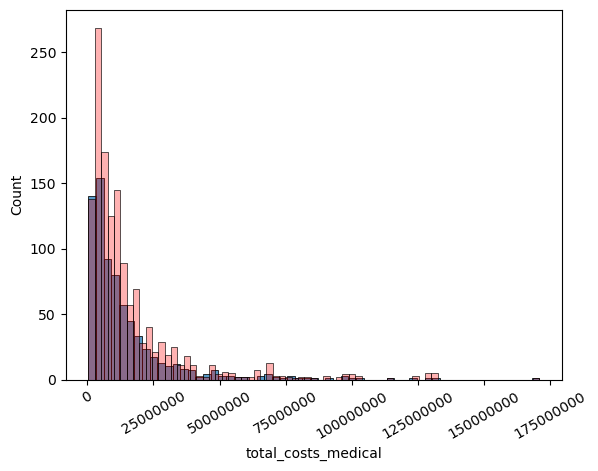

In [61]:
fig, ax = plt.subplots()
ax.ticklabel_format(style='plain', axis='both')
plt.xticks(rotation=30)
sns.histplot(revised_df['total_costs_medical'], ax=ax)
sns.histplot(mice_imputation['total_costs_medical'], color='r', alpha=0.3, ax=ax);

## **Notes and Next Steps**

Ok, now that I have handled all missing values, I will be able to perform EDA and conduct sensitivity analysis to see how the imputations affected the data. 

*Suggested Strategy*

1. Establish a Baseline Analysis

I'll perform EDA using the dataset with the initial imputation methods (random integers between 1 and 15 & MICE). I'll document the results of this analysis and use this as my baseline for comparison.

2. Vary Imputation Methods

I'll apply different imputation methods to the missing data to create several versions of my dataset. 

    For the `health_centers` dataframe, instead of imputing missing values by randomly selecting numbers within the suppressed range (1-15), I could try mean/median imputation. 

    Also, for the `health_centers_ops_finance` dataframe, I could try either removing the columns with missing data or mean/median imputation to see how that would affect analysis.

3. Re-Analyze the Data

I will re-run my analyses (e.g., statistical tests, regression models) on the newly imputed datasets.

4. Compare Results

I'll examine how the results vary across the different imputation methods, specifically looking at:
    * Consistency: Check if key metrics (e.g., coefficients in regression, statistical significance) remain consistent across methods.
    * Deviation: Identify which results deviate significantly and investigate why.

5. Document Findings

I'll document my analysis findings, methods, results, and interpretation.

6. Decision Making

Based on the sensitivity analysis, I'll decide on the most appropriate imputation method my your final analysis and model development.